In [105]:
%matplotlib inline
%run 'notebook_utils.py'

import sys
import pprint
import cProfile

import matplotlib.pyplot as plt
import numpy             as np
import pandas as pd

import radical.utils     as ru
import radical.pilot     as rp
import radical.analytics as ra
import radical.entk as re

from   radical.utils.profile import *
from   radical.pilot.states  import *
import glob
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import AutoMinorLocator

In [12]:
# Load wrangled data saved in .csv files for both synapse, microbenchmarks and gromacs.
sessions = pd.read_csv('../data/sessions.csv', index_col=0)
pilots = pd.read_csv('../data/pilots.csv', index_col=0)
units = pd.read_csv('../data/units.csv', index_col=0)

In [26]:
agg_sessions = sessions[
    ['nunit','TTC','P_LRMS_QUEUING','U_AGENT_QUEUING','U_AGENT_SCHEDULING','U_AGENT_QUEUING_EXEC','U_AGENT_EXECUTING', 'util_u_pre_exec',
    'util_u_eprep','util_u_equeue','util_u_exec_cu','util_u_exec_rp']
        ].groupby(['nunit']).aggregate(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std'],
                 'util_u_pre_exec'     : ['mean','std'],
                 'util_u_eprep'        : ['mean','std'],
                 'util_u_equeue'       : ['mean','std'],
                 'util_u_exec_cu'      : ['mean','std'],
                 'util_u_exec_rp'      : ['mean','std'],
                 'util_u_pre_exec'     : ['mean','std']})

agg_sessions.rename({'util_u_eprep'        :'cu_prep'}, axis='columns', inplace=True)
agg_sessions.rename({'util_u_equeue'       :'scheduler_queue_cu'}, axis='columns', inplace=True)
agg_sessions.rename({'util_u_exec_cu'      :'os_spawns_cu'}, axis='columns', inplace=True)
agg_sessions.rename({'util_u_exec_rp'      :'executor_spawning_cu'}, axis='columns', inplace=True)
agg_sessions.rename({'util_u_pre_exec'     :'pre_executables_cu'}, axis='columns', inplace=True)

agg_sessions.rename({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
agg_sessions.rename({'U_AGENT_QUEUING'     :'agent_queueing'}, axis='columns', inplace=True)
agg_sessions.rename({'U_AGENT_SCHEDULING'  :'agent_scheduling'}, axis='columns', inplace=True)
agg_sessions.rename({'U_AGENT_QUEUING_EXEC':'agent_queue_exec'}, axis='columns', inplace=True)
agg_sessions.rename({'U_AGENT_EXECUTING'   :'TTX'}, axis='columns', inplace=True)

agg_sessions.rename(index={i: '%s/%s' % (i, i*24) for i in agg_sessions.index.get_values()}, inplace=True)
agg_sessions

executor_spawning_cu           agent_queueing           pre_executables_cu             cu_prep           os_spawns_cu              ...          TTQ            agent_queue_exec                  TTX                     TTC              scheduler_queue_cu          
                        mean       std           mean       std               mean       std      mean       std         mean       std    ...         mean        std             mean       std       mean       std          mean          std               mean       std
nunit                                                                                                                                      ...                                                                                                                                
64/1536              1.82745  0.117875         0.0071  0.000141            1.01025  0.135552  0.490251  0.011102       1.8649  0.122047    ...     55.37455  32.584541           1.7852  0.119501  602.12155  0.103167  1.536523e+09  2584.211676            1.78725  0.119289

[1 rows x 22 columns]

In [27]:
agg_pilots = pilots[
    ['nunit','util_p_total','util_p_boot','util_p_term','util_p_uexec']
        ].groupby(['nunit']).aggregate(
                {'util_p_total'        : ['mean','std'],
                 'util_p_boot'         : ['mean','std'],
                 'util_p_term'         : ['mean','std'],
                 'util_p_uexec'        : ['mean','std']})


# 'orte_dvm_start'  is not captured in APRUN

agg_pilots.rename({'util_p_total'        :'p_total'}, axis='columns', inplace=True)
agg_pilots.rename({'util_p_boot'         :'p_bootstraps'}, axis='columns', inplace=True)
agg_pilots.rename({'util_p_term'         :'p_term'}, axis='columns', inplace=True)
agg_pilots.rename({'util_p_uexec'        :'p_uexec'}, axis='columns', inplace=True)

agg_pilots.rename(index={i: '%s/%s' % (i, i*24) for i in agg_pilots.index.get_values()}, inplace=True)
agg_pilots

p_term       p_uexec           p_total     p_bootstraps    
          mean std      mean       std    mean std         mean std
nunit                                                              
64/1536    NaN NaN  638.0895  2.314219     NaN NaN          NaN NaN

(-0.5, 0.4)

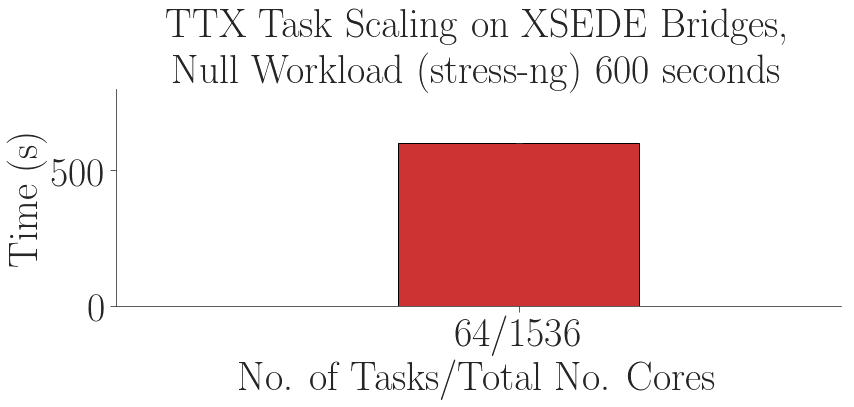

In [95]:
fig, ax = fig_setup(figsize=(13,4))

width = 0.3
ax = agg_sessions['TTX'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std', 
    width=width, color=tableau20[6], ax=ax, rot=0, # position=-0.5, secondary_y=True,
    title='TTX Task Scaling on XSEDE Bridges, \n Null Workload (stress-ng) 600 seconds',
    legend=False)

ax.set_xlabel('No. of Tasks/Total No. Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0,800)
ax.set_xlim(-0.5)

In [123]:
re_folder = glob.glob('../data/exp1/re.*')

src = '/Users/JumanaDakka/git/hyperspace-RCT/null_workload/data/exp1/'

enTK_session = ra.Session(stype = 'radical.entk', src = src, sid = 're.session.two.jdakka.017783.0008')
enTK_states = enTK_session.list('state') # EXECUTED
enTK_tasks = enTK_session.filter(etype = 'task') # , uid = task_ids

sched_duration = enTK_tasks.duration(event=[{ru.EVENT: 'state',
                                    ru.STATE: re.states.SCHEDULING},
                                    {ru.EVENT: 'state',
                                    ru.STATE: re.states.SUBMITTED}])
                                    
comp_duration = enTK_tasks.duration(event=[{ru.EVENT: 'state',
                                    ru.STATE: re.states.SUBMITTED},
                                    {ru.EVENT: 'state',
                                    ru.STATE: re.states.COMPLETED}])


done_duration = enTK_tasks.duration(event=[{ru.EVENT: 'state',
                                    ru.STATE: re.states.COMPLETED},
                                    {ru.EVENT: 'state',
                                    ru.STATE: re.states.DONE}])

entk_df = [sched_duration, comp_duration, done_duration]